In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw.rdMolDraw2D import MolDraw2DCairo
from rdkit.Chem.Draw.rdMolDraw2D import MolDrawOptions
from rdkit.Geometry.rdGeometry import Point2D
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from typing import *
from PIL import Image
import io

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from rdkit_heatmaps import heatmaps

In [4]:
def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

In [5]:
test_mol = Chem.MolFromSmiles("c1ccccc1-C-c2ccccc2")
test_mol = Draw.PrepareMolForDrawing(test_mol)

In [6]:
class GaussFunction:
    def __init__(self, center, std, scale):
        self.center = np.array(center)
        self.std = std
        self.scale = scale
        self.f =  self.scale# * np.sqrt(1 / (2 * np.pi * self.std ** 2))

    def dist(self, pos):
        return np.linalg.norm(pos - self.center)

    def dist_squared(self, pos):
        diff = pos - self.center
        return np.sum(diff ** 2, axis=1)

    def __call__(self, x, y):
        pos = np.stack([x, y], axis=1)
        e = np.exp(-self.dist_squared(pos) / (2 * self.std ** 2))
        return self.f * e

In [7]:
class GaussFunctionAlong:
    def __init__(self, center1, center2, std, scale, cap):
        self.center1 = np.array(center1)
        self.center2 = np.array(center2)
        self.std = std
        self.scale = scale
        self.functions = []
        points = np.linspace(0+cap,1-cap, 10)
        delta = self.center2 - self.center1
        for point in points:
            center = self.center1 + delta * point
            self.functions.append(GaussFunction(center, self.std, 1))

    def __call__(self, x, y):
        out_values = []
        for f in self.functions:
            out_values.append(f(x,y))
        out_values = np.stack(out_values, axis=1)
        out_values = np.max(out_values, axis=1)
        out_values *= self.scale
        return out_values

In [8]:
def get_mol_lims(mol: Chem.Mol) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    coords = []
    conf = mol.GetConformer(0)
    for i, _ in enumerate(mol.GetAtoms()):
        pos = conf.GetAtomPosition(i)
        coords.append((pos.x, pos.y))
    coords = np.array(coords)
    min_p = coords.min(axis=0)
    max_p = coords.max(axis=0)
    x_lim = min_p[0], max_p[0]
    y_lim = min_p[1], max_p[1]
    return x_lim, y_lim

In [9]:
def pad(lim, ratio):
    diff = max(lim) - min(lim)
    diff *= ratio
    diff /= 2
    return [lim[0]- diff, lim[1] + diff]

In [63]:
xl, yl = get_mol_lims(test_mol)
xl = pad(xl, 1)
yl = pad(yl, 1)
v_map = heatmaps.ValueGrid(xl, yl, 1000, 500)
conf = test_mol.GetConformer(0)
f = GaussFunction((0,0), 0.3, 1)
v_map.add_function(f)
for i, _ in enumerate(test_mol.GetAtoms()):
    pos = conf.GetAtomPosition(i)
    coords = pos.x, pos.y
    scale = i & 1
    scale = (scale-0.5) * 2
    f = GaussFunction(coords, 0.25, -1)
    v_map.add_function(f)
    
for i, b in enumerate(test_mol.GetBonds()):  # type: Chem.Bond
    a1 = b.GetBeginAtom().GetIdx()
    a2 = b.GetEndAtom().GetIdx()
    a1_pos = conf.GetAtomPosition(a1)
    a1_coords = a1_pos.x, a1_pos.y
    a2_pos = conf.GetAtomPosition(a2)
    a2_coords = a2_pos.x, a2_pos.y
    scale = i & 1
    scale = (scale-0.5) * 2
    v_map.add_function(GaussFunctionAlong(a1_coords, a2_coords, 0.12, 1, cap=0.3))

v_map.recalculate()

In [64]:
v_map.values.min(), v_map.values.max()

(-0.9981131541802803, 0.9996515818246778)

In [65]:
c_grid = v_map.map2color("bwr", v_lim=[-1, 1])

In [76]:
c_grid.color_grid[:,:,3] = 1

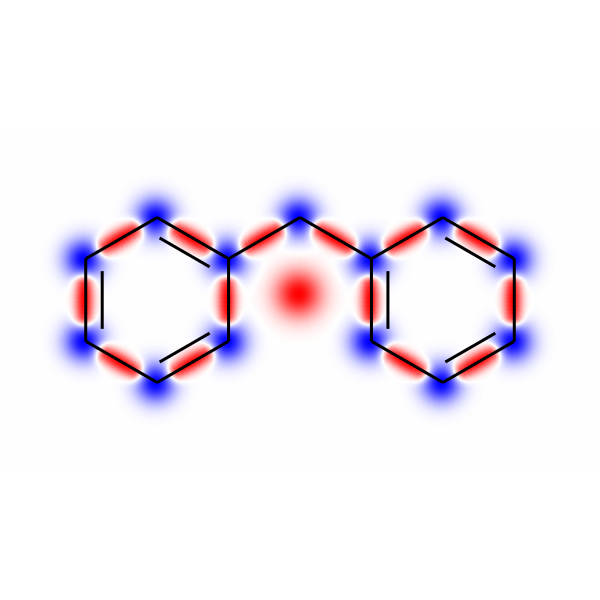

In [77]:
d = MolDraw2DCairo(600, 600)
do = d.drawOptions()
do.padding = 0.2
do.bondLineWidth = 3
d.SetDrawOptions(do)
d.DrawMolecule(test_mol)
heatmaps.color_canvas(d, c_grid)
d.DrawMolecule(test_mol)
show_png(d.GetDrawingText())

In [135]:
image = np.array(Image.open('039.jpg'))
image = image / 255
image = np.flip(image, axis=0)
ones = np.ones([*image.shape[:2], 1])
image = np.append(image, ones, axis=2)
image = np.swapaxes(image,1,0)
s = 5
c_grid = heatmaps.ColorGrid([s,-s], [s/8*4.5,-s/8*4.5], 800, 450)
c_grid.color_grid = image

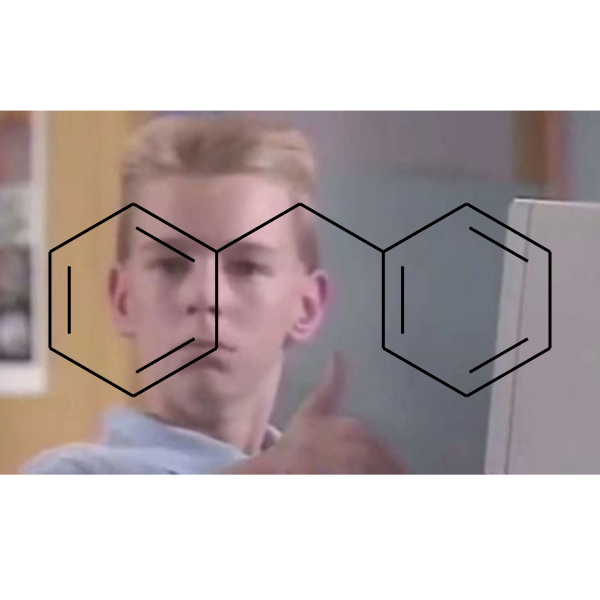

In [138]:
d = MolDraw2DCairo(600, 600)
do = d.drawOptions()
do.padding = 0.1
do.bondLineWidth = 3
d.SetDrawOptions(do)
d.DrawMolecule(test_mol)
heatmaps.color_canvas(d, c_grid)
d.DrawMolecule(test_mol)
show_png(d.GetDrawingText())

In [137]:
4 / 800 * 450

2.25

In [85]:
xl, yl

([-7.79422863405995, 7.794228634059948],
 [-3.1153846153846168, 2.884615384615387])

In [112]:
image.shape

(4, 800, 450)